### -- description ---
this code shows example on identifying high-quality samples using the Cook's distance for both model validation and training


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import preprocessing

# Set random seed for reproducibility
np.random.seed(42)

import os
cwd = '/mnt/poseidon/remotesensing/arctic/data/training/Test_05/'
os.chdir(cwd)
os.getcwd

## make path to save the validation and remaining plots
vers = '05/'
result_path = cwd + 'results/' + vers
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [5]:
# ABR_fcover = pd.read_csv(cwd + 'fcover/ABR_fcover_parent_01.csv')
common_col = ['Site Code', 'bare ground top cover (%)',
       'deciduous shrub total cover (%)', 
       'evergreen shrub total cover (%)', 
       'forb total cover (%)', 'graminoid total cover (%)',
       'litter total cover (%)', 'non-vascular total cover (%)',
       'water top cover (%)', 'latitude', 'longitude', 'plot_radius_m',
       'source', 'year','field sampling method', 'cover measurement']

trg = 'child'   # change to parent if needed

In [6]:
### load plot fCover and aux info
ABR_fcover = pd.read_csv(cwd + 'fcover/ABR_fcover_'+trg+'_01.csv')[common_col]
VEG_fcover = pd.read_csv(cwd + 'fcover/VEG_fcover_'+trg+'_01.csv')[common_col]
AVA_fcover = pd.read_csv(cwd + 'fcover/AVA_fcover_'+trg+'_01.csv')[common_col]
NEO_fcover = pd.read_csv(cwd + 'fcover/NEO_fcover_'+trg+'_01.csv')[common_col]
SP_fcover = pd.read_csv(cwd + 'fcover/SP_fcover_'+trg+'_01.csv')[common_col]
All_fcover = pd.concat([VEG_fcover, ABR_fcover, AVA_fcover, NEO_fcover, SP_fcover])
All_fcover['Site Code'] = 'id_' + All_fcover['Site Code'].astype(str)

### remove rows with NaN fcover


In [7]:
PFT_col = [col for col in All_fcover.columns if 'cover (%)' in col]  # column used for PFT selection
All_fcover = All_fcover.dropna(subset=PFT_col, how='all')
All_fcover = All_fcover.fillna(0)
All_fcover['source'].unique()

array(['AKVEG_AIM_NPRA', 'ABR_RS', 'AKAVA', 'NEON', 'NGEE_SP'],
      dtype=object)

In [8]:
### load plot satellite based features
rad = '30m'  # radius for sampling plot's satellite features

Spectra = pd.read_csv(cwd + 'features/'+trg+'/'+trg+'_S2_summer_2019_med_'+rad+'.csv')
Spectra['Site Code'] = 'id_' + Spectra['Site Code'].astype(str)
Spectra = Spectra.dropna(subset=['B2_median', 'B3_median', 'B4_median', 'B5_median', 
        'B6_median', 'B7_median', 'B8A_median', 'B8_median',
        'B11_median', 'B12_median'], how='any')

spectra = Spectra.merge(All_fcover[['Site Code']], how='inner', on='Site Code')
# spectra.shape

### ensure all plot columns are matched
# print(ABR_fcover.columns == VEG_fcover.columns)

In [9]:
All_fcover = All_fcover.merge(Spectra[['Site Code']], how='inner', on='Site Code')
# All_fcover['Site Code'] == Spectra['Site Code']
# spectra = spectra.sort_values(by=All_fcover['Site Code'])
# All_fcover['Site Code'] == Spectra['Site Code']

In [10]:
band = ['B2_median', 'B3_median', 'B4_median', 'B5_median', 
        'B6_median', 'B7_median', 'B8A_median', 'B8_median',
        'B11_median', 'B12_median']
spectra[band] = spectra[band]*0.0001 #rescaled to 0-1
spectra_all = spectra.copy()[band]
new_cols = ['blue','green','red','redEdge1','redEdge2', 'redEdge3', 'redEdge4', 
            'nir', 'swir1', 'swir2']
spectra_all.rename(columns={col: new_cols[i] for i, col in enumerate(spectra_all.columns)}, inplace=True)

In [11]:
def vegIDXcal(vegIDX):
    nir = vegIDX['nir']
    red = vegIDX['red']
    green = vegIDX['green']
    blue = vegIDX['blue']
    swir1 = vegIDX['swir1']
    swir2 = vegIDX['swir2']
    redEdge1 = vegIDX['redEdge1']
    
    vegIDX['ndwi1'] = (nir - swir1)/(nir + swir2)
    vegIDX['ndwi2'] = (nir - swir2)/(nir + swir2)
    vegIDX['msavi'] = (2*nir + 1 -  ((2*nir + 1)**2 - 8*(nir - red))**0.5) * 0.5
    vegIDX['vari'] = (green - red)/(green + red - blue);
    vegIDX['rvi'] = nir/red
    vegIDX['osavi'] = 1.16 * (nir - red)/(nir + red + 0.16)
    vegIDX['tgi'] = (120 * (red - blue) - 190 * (red - green))*0.5
    vegIDX['gli'] = (2 * green - red - blue)/(2 * green + red + blue)
    vegIDX['ngrdi'] = (green - red)/(green + red)
    vegIDX['ci_g'] = nir/green - 1
    vegIDX['gNDVI'] = (nir - green)/(nir + green)
    vegIDX['cvi'] = (nir * red)/(green ** 2)
    vegIDX['mtvi2'] = 1.5*(1.2*(nir - green) - 2.5*(red - green))/(((2*nir + 1)**2 - (6*nir - 5*(red**0.5))-0.5)**0.5)

    vegIDX['brightness'] = 0.3037 * blue +0.2793 * green +0.4743 * red +0.5585 * nir +0.5082 * swir1 + 0.1863 * swir2
    vegIDX['greenness'] = 0.7243 * nir +0.0840 * swir1 - 0.2848 * blue - 0.2435 * green - 0.5436 * red - 0.1800 * swir2 	
    vegIDX['wetness'] = 0.1509 * blue+0.1973* green+0.3279*red+0.3406*nir-0.7112*swir1 - 0.4572*swir2
    vegIDX['tcari'] = 3 * ((redEdge1 -red)-0.2 * (redEdge1- green)*(redEdge1/red))
    vegIDX['tci'] = 1.2 * (redEdge1 - green)- 1.5 * (red - green)*((redEdge1/red)**0.5)
    vegIDX['nari'] = (1/green - 1/redEdge1)/(1/green + 1/redEdge1)
    return vegIDX
    
vegIDX = vegIDXcal(spectra_all)

### extract the PFT column for quality control analysis

In [12]:
import re
def extract_non_specific_substrings(input_list, substrings_to_exclude):
    result_list = []

    for string in input_list:
        # Construct a regular expression pattern to exclude specific substrings
        pattern = re.compile('|'.join(map(re.escape, substrings_to_exclude)))
        
        # Use regular expression to find substrings not containing specific substrings
        non_specific_substrings = pattern.split(string)
        result_list.extend(non_specific_substrings)

    # Filter out empty strings
    result_list = [substring for substring in result_list if substring]

    return result_list

PFT_list = extract_non_specific_substrings(PFT_col, [' total cover (%)',' top cover (%)']) # column used for naming or storing data
print(PFT_list) 

['bare ground', 'deciduous shrub', 'evergreen shrub', 'forb', 'graminoid', 'litter', 'non-vascular', 'water']


### quality control, test with one PFT

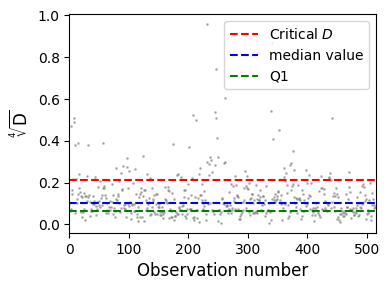

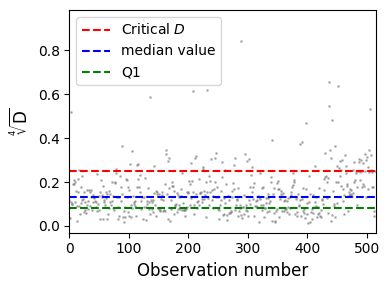

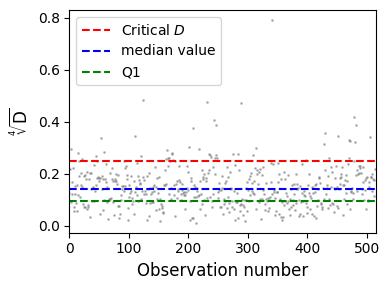

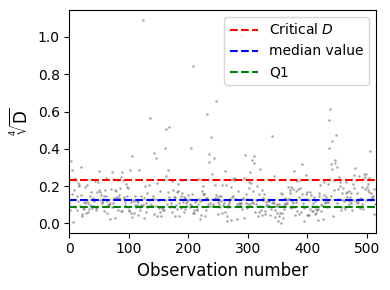

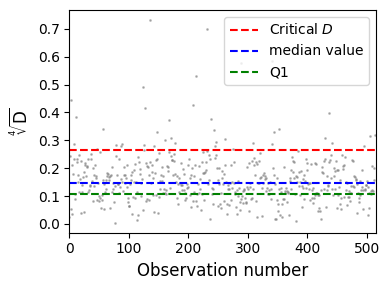

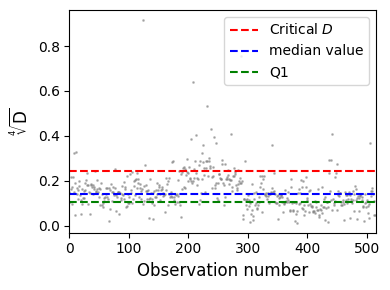

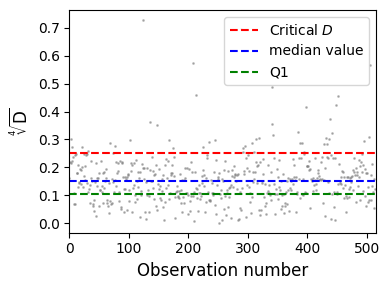

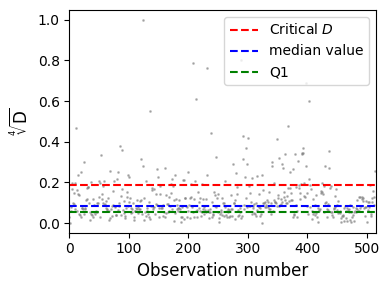

In [13]:
data = All_fcover.copy()

for i, pft in enumerate(PFT_col):
    x = vegIDX.copy()

    ## test with a PFT
    PFT = All_fcover[pft]*0.01
    y = PFT.copy()

    # # Check if the DataFrame contains any NaN or inf values
    # contains_nan_inf_x = x.isna().any().any() or not np.isfinite(x.values).all()
    # contains_nan_inf_y = y.isna().any().any() or not np.isfinite(y.values).all()
    
    # if contains_nan_inf_x: 
    #     print("x contains NaN or inf values.")
    # elif contains_nan_inf_y:
    #     print("y contains NaN or inf values.")
    # else:
    #     print("DataFrame does not contain NaN or inf values.")
        
    ## prepare x for the model
    min_max_scaler = preprocessing.MinMaxScaler()
    x = min_max_scaler.fit_transform(x)
    
    #%% remove outliers by Cook's Distance
    # --- model fit ---
    glm_gaussian = sm.GLM(y,x, family=sm.families.Gaussian())
    model = glm_gaussian.fit()
    
    #--- cook's distance calculation ---
    GLMinf = model.get_influence(observed=False)
    np.set_printoptions(suppress=True)
    
    cooks = GLMinf.cooks_distance
    data['cooks_' + PFT_list[i]] = cooks[0]

    ####--- extracting the highest quality used for validation---
    flag1 = data['cooks_' + PFT_list[i]]<np.quantile(cooks[0],0.25)
    flag2 = data['source'].isin(['AKVEG_AIM_NPRA','ABR_RS'])
    true_indices = np.where(flag1 & flag2)[0]
    
    # Calculate the number of True values to select (20% of the total True values)
    num_to_select = int(0.5 * len(true_indices))
    
    # Randomly select 20% of the True values
    selected_indices = np.random.choice(true_indices, size=num_to_select, replace=False)
    
    # Create a new logic column with False for all rows
    data['val_' + PFT_list[i]] = False
    
    # Set the selected indices to True in the new logic column
    data.loc[selected_indices, 'val_' + PFT_list[i]] = True
    
    ## ---- plot the critical distance ---
    thres1 = (np.quantile(cooks[0],0.75) - np.quantile(cooks[0],0.25))*2 + np.quantile(cooks[0],0.75)
    
    fig, ax = plt.subplots(figsize=(4,3))
    plt.rcParams.update(plt.rcParamsDefault)
    #----scatter
    plt.scatter(np.arange(0,data.shape[0]), cooks[0]**0.25,s=1,alpha = 0.5,c='grey')
    plt.xlabel('Observation number',fontsize = 12)
    plt.ylabel(r"$\sqrt[4]{\rm{D}}$",fontsize = 12)
    plt.axhline(y= thres1**0.25, color='r', 
                linestyle='--',label='Critical '+ r'$D$') #alpha = 0.05
    plt.axhline(y= np.quantile(cooks[0],0.5)**0.25, color='b', 
                linestyle='--',label='median value') #alpha = 0.05
    plt.axhline(y= np.quantile(cooks[0],0.25)**0.25, color='g', 
                linestyle='--',label='Q1') #alpha = 0.05
    plt.xlim([0, x.shape[0]+1])
    plt.legend()
    plt.tight_layout()
    # plt.show()
    
    output_filename = os.path.join(result_path, 'criticalDistance_validSampleSelection_{}_2IQR_{}.png'.format(PFT_list[i],
                                                                                                             rad))
    plt.savefig(output_filename)

# save validation index for modeling
data.to_csv(result_path + trg+'_fcover_valIDX_'+rad + '_01.csv')


In [21]:
vegIDX['Site Code'] = spectra['Site Code']
vegIDX['source'] = spectra['source']
vegIDX.to_csv(cwd + 'feature/'+trg+'/'+trg+'_S2_summer_2019_med_'+rad+'_expanded.csv')